# Dataset des 2 lunes

(Avec un nouvel affichage plus joli, merci Arthur !)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

def generate_2moons_dataset(num_lab = 10, num_unlab=740, num_test=250):
  num_samples = num_lab + num_unlab + num_test
  # Génération de 1000 données du dataset des 2 lunes
  x, y = datasets.make_moons(n_samples=num_samples, noise=0.1, random_state=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=num_test/num_samples, random_state=1)
  x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=num_unlab/(num_unlab+num_lab), random_state=6)

  return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test

(10, 2) (740, 2) (250, 2)
(10,) (740,) (250,)


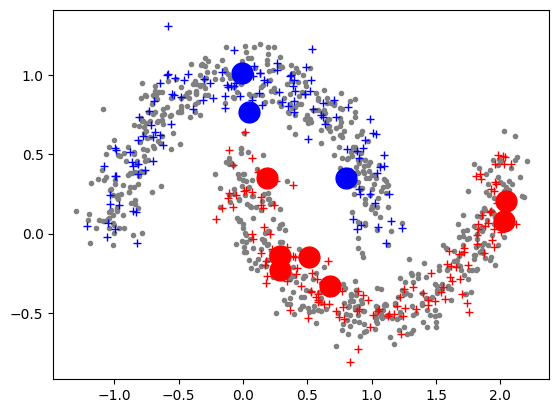

In [2]:
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_2moons_dataset(num_lab = 10, num_unlab=740, num_test=250)

print(x_train_lab.shape, x_train_unlab.shape, x_test.shape)
print(y_train_lab.shape, y_train_unlab.shape, y_test.shape)

# Affichage des données
plt.plot(x_train_unlab[y_train_unlab==0,0], x_train_unlab[y_train_unlab==0,1], color=(0.5,0.5,0.5), marker='.', linestyle=' ')
plt.plot(x_train_unlab[y_train_unlab==1,0], x_train_unlab[y_train_unlab==1,1], color=(0.5,0.5,0.5), marker='.', linestyle=' ')

plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+')

plt.plot(x_train_lab[y_train_lab==0,0], x_train_lab[y_train_lab==0,1], 'b.', markersize=30)
plt.plot(x_train_lab[y_train_lab==1,0], x_train_lab[y_train_lab==1,1], 'r.', markersize=30)

plt.show()

In [3]:
def create_model_2moons():

  inputs = keras.Input(shape=(2,))
  x = Dense(20, activation="relu")(inputs)
  outputs = Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

# $\Pi$-Modèle

Nous allons maintenant tenter d'utiliser un 2nd algorithme semi-supervisé supposé être plus efficace, il s'agit de l'algorithme du $\Pi$-Modèle, dont la version détaillée est présentée ci-dessous (en VO).

<img src="https://drive.google.com/uc?id=13VhlBYwA6YIYGzKI81Jom_jTiuhOypEg">
<caption><center> Figure 1 : Pseudo-code de l'algorithme du $\Pi$-Modèle</center></caption>


Ci-dessous, la boucle d'entraînement détaillée est reprise et contient un squelette du code à réaliser pour implémenter le $\Pi$-Modèle.

**Travail à faire :** Complétez le squelette de l'algorithme du $\Pi$-Modèle pour pouvoir tester ce nouvel algorithme.

In [4]:
import tensorflow as tf
from tensorflow import keras
import math
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

# Nombre d'epochs de l'apprentissage
epochs = 2000
# Nombre de données non-labellisées par batch
bs_unlab = 100
# Nombre de données labellisées par batch
bs_lab = 10
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_2moons_dataset(num_lab = 10, num_unlab=740, num_test=250)
model = create_model_2moons()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
### complété
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.BinaryCrossentropy()
# L'autre pour la partie non-supervisée de la perte
def loss_unsup(y_pred_unlab, y_pred_unlab_noisy, lambda_t):
    loss = lambda_t * keras.losses.MeanSquaredError()(y_pred_unlab, y_pred_unlab_noisy)
    return loss

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch alternatif constitué des mêmes données bruitées
    # Le bruit ici sera simplement obtenu avec np.random.rand()
    # Attention à l'échelle du bruit (il faut le multiplier par un scalaire pour qu'il ne soit pas trop important)!
    ### complété
    x_batch_noisy = x_batch + 0.1* np.random.rand(*x_batch.shape)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !
      y_pred_noisy = model(x_batch_noisy, training=True)

      # Calcul de la fonction de perte sur ce batch
      ### complété
      sup_term = loss_sup(y_batch_lab[0:bs_lab], y_pred[0:bs_lab])
      unsup_term = loss_unsup(y_pred[bs_lab:], y_pred_noisy[bs_lab:], lambda_t)
      print(unsup_term)

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 100:
      lambda_t = lambda_t + 0.01




tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    0 : Loss : 0.6535, Acc : 0.7000, Val Acc : 0.5360
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    1 : Loss : 0.6386, Acc : 0.7000, Val Acc : 0.5520
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    2 : Loss : 0.6237, Acc : 0.7000, Val Acc : 0.5600
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    3 : Loss : 0.6091, Acc : 0.7000, Val Acc : 0.5680
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    4 : Loss : 0.5948, Acc : 0.7000, Val Acc : 0.5920
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    5 : Loss : 0.5808, Acc : 0.7000, Val Acc : 0.6000
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    6 : Loss : 0.5673, Acc : 0.7000, Val Acc : 0.6160
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    7 : Loss : 0.5541, Acc : 0.7000, Val Acc : 0.6360
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    8 : Loss : 0.5413, Acc : 0.7000, Val Acc : 0.6480
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    9 : Loss : 0.5288, Acc : 0.7000, Val Acc : 0.6840
tf.Tensor(

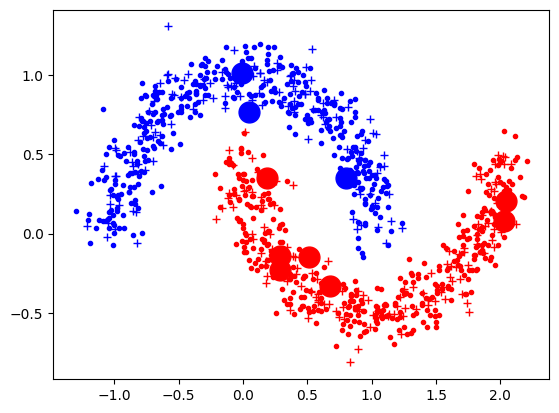

9600/9600 [==============================] - 17s 2ms/step


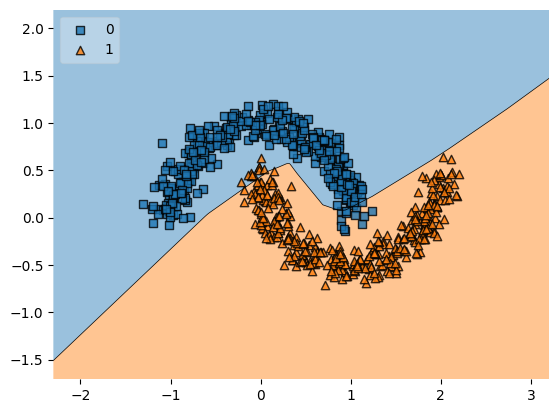

In [5]:
from mlxtend.plotting import plot_decision_regions

# Affichage des données
plt.plot(x_train_unlab[y_train_unlab==0,0], x_train_unlab[y_train_unlab==0,1], 'b.')
plt.plot(x_train_unlab[y_train_unlab==1,0], x_train_unlab[y_train_unlab==1,1], 'r.')

plt.plot(x_test[y_test==0,0], x_test[y_test==0,1], 'b+')
plt.plot(x_test[y_test==1,0], x_test[y_test==1,1], 'r+')

plt.plot(x_train_lab[y_train_lab==0,0], x_train_lab[y_train_lab==0,1], 'b.', markersize=30)
plt.plot(x_train_lab[y_train_lab==1,0], x_train_lab[y_train_lab==1,1], 'r.', markersize=30)

plt.show()

# Plot decision boundary
plot_decision_regions(x_train_unlab, y_train_unlab, clf=model, legend=2)
plt.show()

# MNIST

Pour adapter l'algorithme du $\Pi$-modèle à MNIST, nous allons devoir remplacer le bruitage des données par de l'augmentation de données.

Commencez par remplir l'ImageDataGenerator (à vous de voir comment dans [la documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)) avec des transformations pertinentes. **Attention** cette étape est cruciale pour obtenir de bons résultats. Il faut intégrer les augmentations les plus fortes possibles, mais être certain qu'elles ne modifient pas le label du chiffre !

In [6]:
from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split

def generate_mnist_dataset(num_lab = 100):

  # Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = np.expand_dims(x_train.astype('float32') / 255., 3)
  x_test = np.expand_dims(x_test.astype('float32') / 255., 3)

  x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=(x_train.shape[0]-num_lab)/x_train.shape[0], random_state=2)

  return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test

x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset()

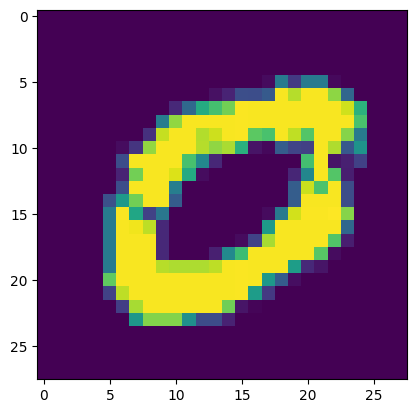

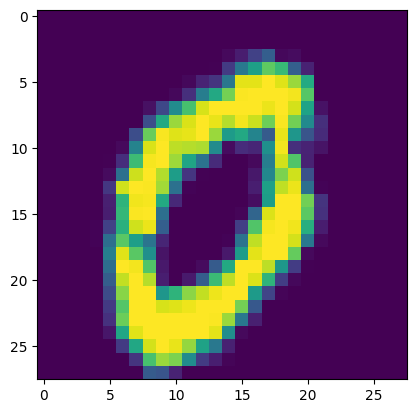

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rotation_range=20,        # Rotation aléatoire dans la plage de [-20, 20] degrés
    width_shift_range=0.1,    # Décalage horizontal aléatoire dans la plage de [-0.1, 0.1] fraction de la largeur totale
    height_shift_range=0.1,   # Décalage vertical aléatoire dans la plage de [-0.1, 0.1] fraction de la hauteur totale
    #shear_range=0.2,          # Étirement aléatoire dans la plage de [-0.2, 0.2] radians
    zoom_range=0.2,           # Zoom aléatoire dans la plage de [0.8, 1.2]
    #horizontal_flip=True,     # Retournement horizontal aléatoire
    vertical_flip=False,      # Pas de retournement vertical
    fill_mode='nearest'       # Mode de remplissage pour les pixels nouvellement créés
)

# Affichage d'une donnée et de son augmentation
x = x_train_lab[0:10]
plt.imshow(x[0, : ,: ,0])
plt.show()
x_aug = train_datagen.flow(x, shuffle=False, batch_size=10).next()
plt.imshow(x_aug[0, : ,: ,0])
plt.show()

Implémentez le réseau LeNet-5 pour la classifications des chiffres manuscrits, en suivant cet exemple :    
<img src="https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg">
<caption><center> Figure 2 : Schéma de l'architecture de LeNet-5</center></caption>

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

# A COMPLETER
# Ici, on implémentera le modèle LeNet-5 :
# 1 couche de convolution 5x5 à 6 filtres suivie d'un max pooling
# puis 1 couche de convolution 5x5 à 16 filtres suivie d'un max pooling et d'un Flatten
# Enfin 2 couches denses de 120 et 84 neurones, avant la couche de sortie à 10 neurones.
def create_model_mnist():

  inputs = keras.Input(shape=(28, 28, 1))  # images MNIST 28x28 avec 1 canal (niveau de gris).

  x = Conv2D(6, kernel_size=(5, 5), activation='relu')(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(16, kernel_size=(5, 5), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Flatten()(x)

  x = Dense(120, activation='relu')(x)
  x = Dense(84, activation='relu')(x)
  outputs = Dense(10, activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

**Travail à faire**

Commencez d'abord par entraîner LeNet-5 sur MNIST de manière supervisée, en **utilisant 100 données labellisées**.

Attention, il va vous falloir modifier quelques élements par rapport à ce que nous avons fait dans la séance précédente, notamment la fonction de coût (*SparseCategoricalCrossEntropy*) et les métriques (*SparseCategoricalAccuracy*).

Pour comparer de manière juste les versions supervisée et semi-supervisée, n'oubliez pas également d'intégrer l'augmentation de données dans votre apprentissage. Vous devriez obtenir environ 80\% de bonnes classifications sur l'ensemble de test.

In [17]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
# Nombre d'epochs de l'apprentissage
epochs = 100
# Nombre de données labellisées par batch
bs_lab = 100
# Taille du batch
batch_size = bs_lab

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset(num_lab = 100)
model = create_model_mnist()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch_lab, training=True)

      # Calcul de la fonction de perte sur ce batch
      sup_term = loss_sup(y_batch_lab, y_pred)

      loss_value = sup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred)


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Epoch    0 : Loss : 2.2994, Acc : 0.1500, Val Acc : 0.1343
Epoch    1 : Loss : 2.2649, Acc : 0.2100, Val Acc : 0.1486
Epoch    2 : Loss : 2.2366, Acc : 0.2300, Val Acc : 0.1709
Epoch    3 : Loss : 2.2076, Acc : 0.2800, Val Acc : 0.1949
Epoch    4 : Loss : 2.1779, Acc : 0.3200, Val Acc : 0.2138
Epoch    5 : Loss : 2.1472, Acc : 0.3500, Val Acc : 0.2306
Epoch    6 : Loss : 2.1145, Acc : 0.3700, Val Acc : 0.2451
Epoch    7 : Loss : 2.0796, Acc : 0.4000, Val Acc : 0.2630
Epoch    8 : Loss : 2.0407, Acc : 0.4100, Val Acc : 0.2865
Epoch    9 : Loss : 1.9967, Acc : 0.4400, Val Acc : 0.3182
Epoch   10 : Loss : 1.9478, Acc : 0.4700, Val Acc : 0.3597
Epoch   11 : Loss : 1.8945, Acc : 0.5400, Val Acc : 0.3941
Epoch   12 : Loss : 1.8370, Acc : 0.5800, Val Acc : 0.4276
Epoch   13 : Loss : 1.7762, Acc : 0.6100, Val Acc : 0.4759
Epoch   14 : Loss : 1.7105, Acc : 0.6500, Val Acc : 0.5011
Epoch   15 : Loss : 1.6391, Acc : 0.6600, Val Acc : 0.5144
Epoch   16 : Loss : 1.5624, Acc : 0.6700, Val Acc : 0.52

En ajoutant des données bruitées.

In [22]:
import tensorflow as tf
from tensorflow import keras
import math
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

# Nombre d'epochs de l'apprentissage
epochs = 50
# Nombre de données non-labellisées par batch
bs_unlab = 100
# Nombre de données labellisées par batch
bs_lab = 100
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset()
model = create_model_mnist()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
### complété
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()
# L'autre pour la partie non-supervisée de la perte
def loss_unsup(y_pred_unlab, y_pred_unlab_noisy, lambda_t):
    loss = lambda_t * keras.losses.MeanSquaredError()(y_pred_unlab, y_pred_unlab_noisy)
    return loss

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch alternatif constitué des mêmes données bruitées
    # Le bruit ici sera simplement obtenu avec np.random.rand()
    # Attention à l'échelle du bruit (il faut le multiplier par un scalaire pour qu'il ne soit pas trop important)!
    ### complété
    x_batch_noisy = x_batch + 0.1* np.random.rand(*x_batch.shape)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !
      y_pred_noisy = model(x_batch_noisy, training=True)

      # Calcul de la fonction de perte sur ce batch
      ### complété
      sup_term = loss_sup(y_batch_lab[0:bs_lab], y_pred[0:bs_lab])
      unsup_term = loss_unsup(y_pred[bs_lab:], y_pred_noisy[bs_lab:], lambda_t)
      print(unsup_term)

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 100:
      lambda_t = lambda_t + 0.01




tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    0 : Loss : 2.3010, Acc : 0.1400, Val Acc : 0.1778
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    1 : Loss : 2.1532, Acc : 0.2500, Val Acc : 0.2521
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    2 : Loss : 1.9612, Acc : 0.3800, Val Acc : 0.3283
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    3 : Loss : 1.6001, Acc : 0.5100, Val Acc : 0.3965
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    4 : Loss : 1.3237, Acc : 0.4900, Val Acc : 0.4975
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    5 : Loss : 1.2902, Acc : 0.6200, Val Acc : 0.6232
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    6 : Loss : 0.8337, Acc : 0.7900, Val Acc : 0.5771
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    7 : Loss : 0.7014, Acc : 0.7500, Val Acc : 0.6414
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    8 : Loss : 0.4849, Acc : 0.8600, Val Acc : 0.6703
tf.Tensor(0.0, shape=(), dtype=float32)
Epoch    9 : Loss : 0.3219, Acc : 0.9100, Val Acc : 0.6984
tf.Tensor(

**Travail à faire**

Reprenez ensuite le code du $\Pi$-Modèle pour l'adapter à MNIST, en intégrant l'augmentation (à la place du bruitage des données). Vous devriez obtenir un gain significatif avec les bons hyperparamètres ! (jusqu'à environ 97\%)

In [24]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
# Nombre d'epochs de l'apprentissage
epochs = 500
# Nombre de données non-labellisées par batch
bs_unlab = 100
# Nombre de données labellisées par batch
bs_lab = 10
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset(num_lab = 100)
model = create_model_mnist()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()
# L'autre pour la partie non-supervisée de la perte
loss_unsup =  keras.losses.MeanSquaredError()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch alternatif constitué des mêmes données bruitées
    x_aug = train_datagen.flow(x_batch, shuffle=False, batch_size=110).next()


    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !
      y_pred_noisy = model(x_aug, training=True)

      # Calcul de la fonction de perte sur ce batch
      sup_term = loss_sup(y_batch_lab, y_pred[:bs_lab])
      unsup_term = loss_unsup(y_pred_noisy, y_pred)

      loss_value = sup_term + lambda_t * unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 10:
      lambda_t = 1

Epoch    0 : Loss : 2.2069, Acc : 0.1700, Val Acc : 0.1922
Epoch    1 : Loss : 2.0084, Acc : 0.2900, Val Acc : 0.2393
Epoch    2 : Loss : 1.6057, Acc : 0.4800, Val Acc : 0.4191
Epoch    3 : Loss : 0.9927, Acc : 0.6100, Val Acc : 0.5886
Epoch    4 : Loss : 0.5170, Acc : 0.7900, Val Acc : 0.6721
Epoch    5 : Loss : 0.1961, Acc : 0.8600, Val Acc : 0.7402
Epoch    6 : Loss : 0.0863, Acc : 0.9400, Val Acc : 0.7783
Epoch    7 : Loss : 0.0355, Acc : 0.9800, Val Acc : 0.7839
Epoch    8 : Loss : 0.0212, Acc : 0.9900, Val Acc : 0.7959
Epoch    9 : Loss : 0.0156, Acc : 0.9900, Val Acc : 0.7818
Epoch   10 : Loss : 0.0110, Acc : 0.9800, Val Acc : 0.8004
Epoch   11 : Loss : 0.0174, Acc : 0.9800, Val Acc : 0.7803
Epoch   12 : Loss : 0.0777, Acc : 0.9800, Val Acc : 0.7738
Epoch   13 : Loss : 0.0703, Acc : 0.9600, Val Acc : 0.7682
Epoch   14 : Loss : 0.0664, Acc : 1.0000, Val Acc : 0.8057
Epoch   15 : Loss : 0.0519, Acc : 1.0000, Val Acc : 0.8046
Epoch   16 : Loss : 0.0506, Acc : 1.0000, Val Acc : 0.80

In [21]:
import tensorflow as tf
from tensorflow import keras
import math
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

# Nombre d'epochs de l'apprentissage
epochs = 500
# Nombre de données non-labellisées par batch
bs_unlab = 100
# Nombre de données labellisées par batch
bs_lab = 100
# Taille du batch
batch_size = bs_lab + bs_unlab
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 0

# Données et modèle du problème des 2 clusters
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset()
model = create_model_mnist()

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_train_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# ICI ON A BESOIN DE DEUX FONCTIONS DE COUT :
### complété
# L'une pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()
# L'autre pour la partie non-supervisée de la perte
def loss_unsup(y_pred_unlab, y_pred_unlab_aug, lambda_t):
    loss = lambda_t * keras.losses.MeanSquaredError()(y_pred_unlab, y_pred_unlab_aug)
    return loss

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  for b in range(steps_per_epochs):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme intègre l'augmentation des données
    x_batch_lab_augmented = train_datagen.flow(x_batch_lab, shuffle=False, batch_size=bs_lab).next()
    x_batch_unlab_augmented = train_datagen.flow(x_batch_unlab, shuffle=False, batch_size=bs_unlab).next()

    x_batch_augmented = np.concatenate((x_batch_lab_augmented, x_batch_unlab_augmented), axis=0)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)
      # Ne pas oublier de le faire également sur le 2e batch !
      y_pred_augmented = model(x_batch_augmented, training=True)

      # Calcul de la fonction de perte sur ce batch
      ### complété
      sup_term = loss_sup(y_batch_lab[0:bs_lab], y_pred[0:bs_lab])
      unsup_term = loss_unsup(y_pred[bs_lab:], y_pred_augmented[bs_lab:], lambda_t)
      #print(unsup_term)

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(np.expand_dims(y_batch_lab, 1), y_pred[0:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test, training=False)
  val_acc_metric.update_state(np.expand_dims(y_test, 1), val_logits)
  val_acc = val_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  # Mise à jour du paramètre de contrôle de l'importance de la régularisation non-supervisée
  # Il augmente progressivement !
  if lambda_t < 1:
    if epoch > 10:
      lambda_t = 1#lambda_t + 0.01


Epoch    0 : Loss : 2.2885, Acc : 0.1100, Val Acc : 0.1506
Epoch    1 : Loss : 2.1893, Acc : 0.1800, Val Acc : 0.1786
Epoch    2 : Loss : 1.9576, Acc : 0.2700, Val Acc : 0.4807
Epoch    3 : Loss : 1.5689, Acc : 0.5800, Val Acc : 0.4736
Epoch    4 : Loss : 1.3070, Acc : 0.6200, Val Acc : 0.5057
Epoch    5 : Loss : 1.0574, Acc : 0.7000, Val Acc : 0.6181
Epoch    6 : Loss : 0.7738, Acc : 0.8100, Val Acc : 0.6376
Epoch    7 : Loss : 0.6598, Acc : 0.7700, Val Acc : 0.6877
Epoch    8 : Loss : 0.4052, Acc : 0.8900, Val Acc : 0.6966
Epoch    9 : Loss : 0.3402, Acc : 0.9200, Val Acc : 0.6888
Epoch   10 : Loss : 0.2108, Acc : 0.9100, Val Acc : 0.6982
Epoch   11 : Loss : 0.1485, Acc : 0.9500, Val Acc : 0.7452
Epoch   12 : Loss : 0.1363, Acc : 0.9900, Val Acc : 0.7707
Epoch   13 : Loss : 0.1318, Acc : 0.9800, Val Acc : 0.7774
Epoch   14 : Loss : 0.1113, Acc : 0.9800, Val Acc : 0.7749
Epoch   15 : Loss : 0.0897, Acc : 0.9900, Val Acc : 0.7714
Epoch   16 : Loss : 0.0726, Acc : 1.0000, Val Acc : 0.77